# Detecting credit card fraud

We create a classifier to detect credit card fraud using both quantum machine learning and classical machine learning techniques.

## Dataset

We load the dataset and take a first glance at it

In [ ]:
from zipfile import ZipFile
import pandas as pd

with ZipFile("Data/creditcard.csv.zip", "r") as zipObj:
    zipObj.extractall()
    credit_df = pd.read_csv("Data/creditcard.csv")
credit_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/creditcard.csv'

In [13]:
credit_df.tail(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


All values in the dataframe are numeric and, as we can see, there are no null values.

In [14]:
credit_df.info() # Datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

We plot the hours at which the fraud and legit transactions take place. We see that at certain times more fraudulent transactions appear.

Text(0, 0.5, '# transactions')

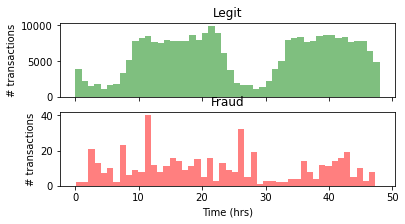

In [21]:
import matplotlib.pyplot as plt
credit_df["Time"] = credit_df["Time"]/3600 # convert to hours
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(credit_df.Time_Hr[credit_df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Legit')
ax2.hist(credit_df.Time_Hr[credit_df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
ax2.set_xlabel('Time (hrs)')
ax1.set_ylabel('# transactions')
ax2.set_ylabel('# transactions')

We see that there are no strong correlations between different columns.

In [17]:
corr = credit_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'})

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Hr
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323,1.000000
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347,0.117396
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289,-0.010593
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961,-0.419618
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447,-0.105260
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974,0.173072
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643,-0.063016
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257,0.084714
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875,-0.036949
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733,-0.008660


Now we look at the main characteristics of the dataset

In [5]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We normalize the time and amount columns, since we are going to use the data in unitary operations –which may be decomposed into rotations– and this can result in many turns around the circle, giving almost random states.

In [32]:
credit_df[['Amount']]=(credit_df[['Amount']]-credit_df[['Amount']].mean())/credit_df[['Amount']].std()
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,...,V13,V16,V17,V18,V19,V21,V26,Amount,Class,Time_Hr
0,0.000000e+00,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,...,-0.991390,-0.470401,0.207971,0.025791,0.403993,-0.018307,-0.189115,0.244964,0,0.000000
1,0.000000e+00,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,...,0.489095,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0.125895,-0.342474,0,0.000000
2,5.953742e-15,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,...,0.717293,-2.890083,1.109969,-0.121359,-2.261857,0.247998,-0.139097,1.160684,0,0.000278
3,5.953742e-15,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,...,0.507757,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,-0.221929,0.140534,0,0.000278
4,1.190748e-14,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,...,1.345852,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0.502292,-0.073403,0,0.000556


We can check the correlations between V1... V28 features to see which ones differ from fraud to legit transactions.

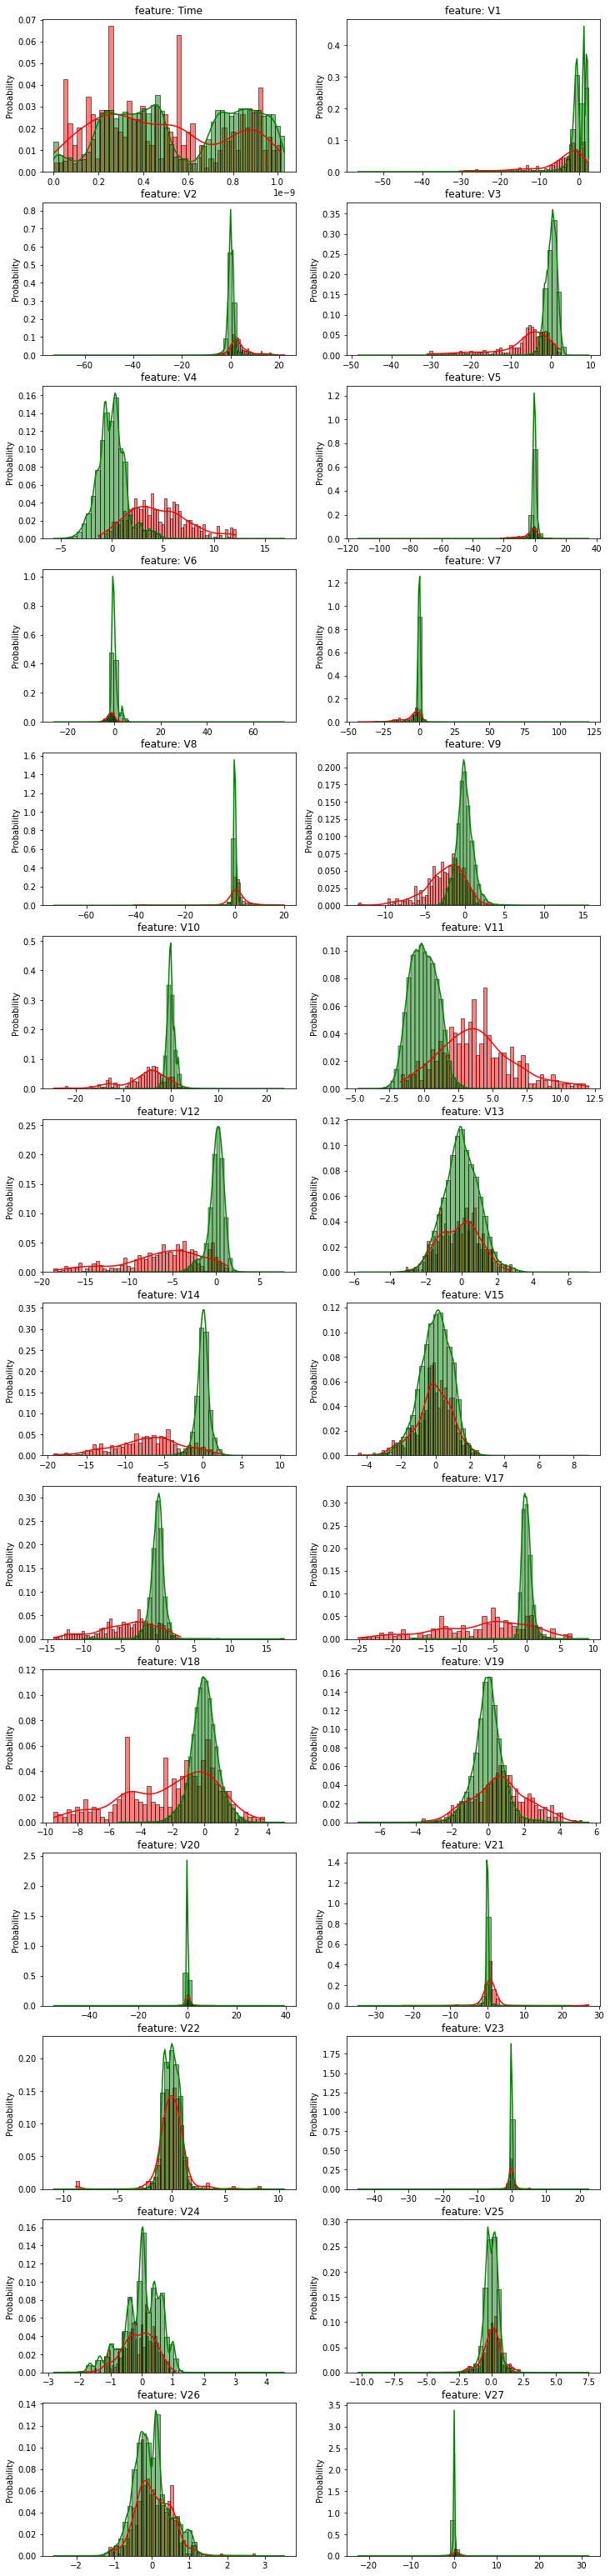

In [30]:
import seaborn as sns
import matplotlib.gridspec as gridspec

plt.close()
gs = gridspec.GridSpec(14, 2)
plt.figure(figsize=(2*6,14*4))
for index, col in enumerate(credit_df[credit_df.iloc[:,0:28].columns]):
    i = index // 2
    j = index%2
    ax5 = plt.subplot(gs[i,j])
    sns.histplot(credit_df[col][credit_df.Class == 1], bins=50, color='r', cbar_kws=dict(alpha=0.3), kde=True, stat='probability')
    sns.histplot(credit_df[col][credit_df.Class == 0], bins=50, color='g', cbar_kws=dict(alpha=0.3), kde=True, stat='probability')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

To reduce the number of parameters, we drop the columns which give similar results

In [31]:
drop_list = ['V8','V14','V15','V20','V22','V23','V24','V25','V27','V28']
credit_df = credit_df.drop(drop_list,axis=1)

In [33]:
feature_df = credit_df[credit_df.columns.drop('Class')]
label_df = credit_df[['Class']]

We convert the dataframe to array

In [1]:
from pennylane import numpy as np

In [35]:
X = np.asarray(feature_df) # shape (284807, 30)
Y = np.asarray(label_df)   # shape (284807, 1)

We save the transformed data in a file, so we don't need to repeat the above process.

In [36]:
np.save('Data/X.npy', X, allow_pickle=True)
np.save('Data/Y.npy', Y, allow_pickle=True)

We may now load the data from the files.

In [2]:
X = np.load('Data/X.npy', allow_pickle=True)
Y = np.load('Data/Y.npy', allow_pickle=True)

## QAOA Optimizer

QAOA or *Quantum Approximate Optimization Algorithm* is a general technique that can be used to find approximate solutions to combinatorial optimization problems. It was developed by Farhi, Goldstone and Gutmann in 2014 [[1]](https://arxiv.org/abs/1411.4028). We will use the circuit envised in the article, 

$$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
    e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$

to guess the class of a given input data (features of our dataframe). Since we only need to predict one of two binary classes, 0 and 1, we can build a circuit with just one qubit and assign the states closer to $\ket{0}$ as class $0$ and states closer to $\ket{1}$ as class $1$.

To guess the class, we use a *cost Hamiltonian* $H_c \equiv Z$, so that $\langle Z \rangle > 0$ corresponds to class $1$ and $\langle Z \rangle < 0$ corresponds to class $0$. If $Y$ are the exact labels and $\hat{Y}$ their approximation, we can create a cost function $\sum 1-\hat{Y}(1-2Y)$ whose minimum gives us the optimum parameters for our circuit. The minimum will be found using machine learning techniques (this mixture of variational quantum circuits and ML is usually known as quantum machine learning or QML).


The time evolution of $H_c$ changes the phase of our initial state. We also need to define a *mixer Hamiltonian* $H_m$, which changes the probabilities of measuring different states. For this purpose, we choose $H_m\equiv X$. Since we need to "upload" our data to the circuit in order to use it, we can input each row of features as the parameters $\alpha_i$ which give the time evolution of $H_c$. Since we also need a set of parameters to train, we can train the parameters $\gamma_i$, which give the time evolution of $H_m$. If we wanted a more complex model, we could surely add more parameters, but it would increase the computation time of the optimum parameters.

### Training the classifier

We divide the set into training and test sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.9, random_state=4)
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (28480, 21) (28480,)
Test set: (256327, 21) (256327,)


In [4]:
from Classifier.quantum_classifier import *
QClass = Q_classifier(X_train, Y_train, X_test, Y_train)

In [ ]:
QClass.optimize_circ()

We got an unexpected error ```IndexError: tuple index out of range``` which for the time being I haven't been able to fix.

## Support Vector Machine Optimizer

In [38]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, Y_train.ravel()) 
Yhat = clf.predict(X_test)

Area Under the Receiving Operator Characteristic (AUROC) is the recommended metric in the dataset documentation, as the classes are highly unbalanced [[2]](https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/).

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Yhat)

0.859536284258018

### Other metrics

As we can see, this is lower than, for example, the f1 score

In [39]:
from sklearn.metrics import f1_score
f1_score(Y_test, Yhat, average='weighted') 

0.9983084544099196

We can also check the confussion matrix score

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [36]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.92      0.72      0.81       146

    accuracy                           1.00     85443
   macro avg       0.96      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443

Normalized confusion matrix
[[1.00e+00 1.06e-04]
 [2.81e-01 7.19e-01]]


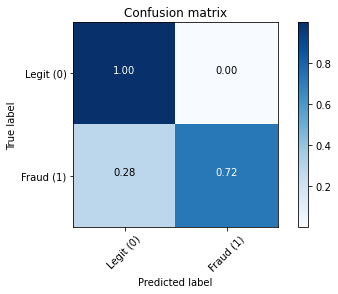

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Yhat, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(Y_test, Yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Legit (0)','Fraud (1)'], normalize = True,  title='Confusion matrix')